In [1]:
import copy

import networkx
import shapely.geometry
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import opentnsim

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0, 0],
    [100000, 0],
    [200000, 0],
    [200000, 150000],
    [200000, 250000],
    [306066, 106066],
    [376777, 176777],
    [350000, 0],
    [450000, 0],
    [217678, -17678],
    [376777, -176777]
]

# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        depth = depths[index],
        width = widths[index],
        geometry=edge_geometry, 
        length= round(edge_geometry.length),
        e=tuple(edge)
    )
    FG.add_edge("Node " + str(edge[0]), "Node " + str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

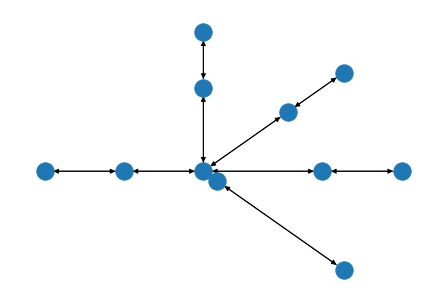

In [6]:
# show graph
nx.draw(FG, positions)
plt.show()

In [7]:
# inspect if properties were set correctly
for edge in FG.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], FG.edges[(edge[0], edge[1])]['Info']['depth']))

Node 0, Node 1: general depth 12.5 m
Node 1, Node 0: general depth 12.5 m
Node 1, Node 2: general depth 6 m
Node 2, Node 1: general depth 6 m
Node 2, Node 3: general depth 6 m
Node 2, Node 5: general depth 4.5 m
Node 2, Node 7: general depth 2.5 m
Node 2, Node 9: general depth 2.5 m
Node 3, Node 2: general depth 6 m
Node 3, Node 4: general depth 6 m
Node 4, Node 3: general depth 6 m
Node 5, Node 2: general depth 4.5 m
Node 5, Node 6: general depth 6 m
Node 6, Node 5: general depth 6 m
Node 7, Node 2: general depth 2.5 m
Node 7, Node 8: general depth 6 m
Node 8, Node 7: general depth 6 m
Node 9, Node 2: general depth 2.5 m
Node 9, Node 10: general depth 6 m
Node 10, Node 9: general depth 6 m


In [8]:
row = {
    "rws_type": "M8",
    "fuel": 3000,
    "H2": 999000,
    "Battery": 3300,
    "E-LNG": 432000,
    "E-Methanol": 165900
}
rows = [row]
ships = pd.DataFrame(rows)
ships

,rws_type,fuel,H2,Battery,E-LNG,E-Methanol
0,M8,3000,999000,3300,432000,165900


In [9]:
def split_edge(edge, distance=100):
    """compute points (list of shapely points) and edges ({e: linestring}) that we can use to replace an edge by points in between"""
    distances = np.arange(0, edge['geometry'].length + distance, distance)
    
    # The determine the points based on the distances
    points = [
        edge['geometry'].interpolate(distance) 
        for distance 
        in distances
    ]
    
    edges = {}
    # loop over the start, end point pairs
    edge_pairs = list(
        zip(
            points[:-1], 
            points[1:]
        )
    )
    for edge_i, (point_a, point_b) in enumerate(edge_pairs):    
        edge_geometry = shapely.geometry.LineString([point_a, point_b])
        node_a = edge_i
        node_b = edge_i + 1
        edges[(node_a, node_b)] = edge_geometry
        
    return points, edges

def split_and_replace_edge(FG, e_replace, edge_info, distance=1000):
    """remove edge from the network and replace it by points in between"""
    
    # determine the points that we want to intersect
    intersection_points, intersection_edges = split_edge(edge_info, distance=distance)
    
    # Try and remove the previous edges, if it fails, that's ok
    try:
        FG.remove_edge(e_replace[0], e_replace[1])
    except nx.NetworkXError:
        pass
    
    # also remove the oposite edge direction
    try:
        FG.remove_edge(e_replace[1], e_replace[0])
    except nx.NetworkXError:
        pass

    # start at the start of our replaced edge
    nodes = []

    node_id = f'{e_replace[0]}'
    node_properties = dict(
        geometry=shapely.geometry.Point((edge_info['geometry'].xy[0][0], edge_info['geometry'].xy[1][0])),
        x=edge_info['geometry'].xy[0][0],
        y=edge_info['geometry'].xy[1][0],
        name=node_id
    )
    nodes.append(node_properties)

    # all the points in between
    for node_i, point in enumerate(intersection_points[1:-1]):
        node_id = f'{e_replace[0]}-{node_i}-{e_replace[1]}'
        node_properties = dict(
            geometry=point,
            x=point.x,
            y=point.y,
            name=node_id
        )
        nodes.append(node_properties)
    
    # end at the end of our edge
    node_id = f'{e_replace[1]}'
    node_properties = dict(
        geometry=shapely.geometry.Point((edge_info['geometry'].xy[0][1], edge_info['geometry'].xy[1][1])),
        x=edge_info['geometry'].xy[0][1],
        y=edge_info['geometry'].xy[1][1],
        name=node_id
    )
    nodes.append(node_properties)

    # add all the node properties, skip first and last, because they already exist
    for node in nodes:
        node_i = node['name']

        # add the nodes in between
        FG.add_node(node_i, **node)
        
    # now loop over all the node pairs in between our edge
    edges = []
    for index, node in enumerate(nodes[:-1]):
        e = (nodes[index]['name'], nodes[index+1]['name'])

        # create a new geometry
        edge_geometry = shapely.geometry.LineString([
            nodes[index]['geometry'], 
            nodes[index+1]['geometry']
        ])
        # we might want to copy the old properties
        # for now this is hard coded
        # at least replace e, edge_geometry
        edge_properties = dict(
            depth= edge_info['depth'], 
            width= edge_info['width'], 
            geometry=edge_geometry, 
            length=edge_geometry.length,
            e=tuple(e)
        )
        edges.append(edge_properties)

    # now that we have all our edges computed
    for edge in edges:
        # insert them in two directions
        e = edge['e']
        FG.add_edge(e[0], e[1], **edge)
        FG.add_edge(e[1], e[0], **edge)
    
    return FG, nodes, edges

In [10]:
edge_name = ("Node " + str(edge_indices[0][0]), "Node " + str(edge_indices[0][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_0 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[1][0]), "Node " + str(edge_indices[1][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_1 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[2][0]), "Node " + str(edge_indices[2][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_2 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[3][0]), "Node " + str(edge_indices[3][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_3 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[4][0]), "Node " + str(edge_indices[4][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_4 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[5][0]), "Node " + str(edge_indices[5][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_5 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[6][0]), "Node " + str(edge_indices[6][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_6 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[7][0]), "Node " + str(edge_indices[7][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_7 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[8][0]), "Node " + str(edge_indices[8][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_8 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

edge_name = ("Node " + str(edge_indices[9][0]), "Node " + str(edge_indices[9][1]))
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_9 = split_and_replace_edge(FG, edge_name, edge_info, distance=1000)

In [11]:
positions = {}
for node in FG.nodes:
    positions[FG.nodes[node]['name']] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)   

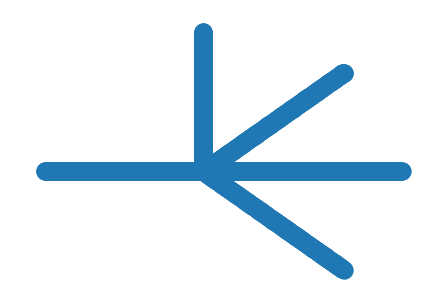

In [12]:
# show graph
nx.draw(FG, positions)
plt.show()

In [13]:
df_split_edge_0 = pd.DataFrame(split_edge_0)
df_split_edge_0.head(3)

,depth,width,geometry,length,e
0,12.5,300,"LINESTRING (0 0, 1000 0)",1000.0,"(Node 0, Node 0-0-Node 1)"
1,12.5,300,"LINESTRING (1000 0, 2000 0)",1000.0,"(Node 0-0-Node 1, Node 0-1-Node 1)"
2,12.5,300,"LINESTRING (2000 0, 3000 0)",1000.0,"(Node 0-1-Node 1, Node 0-2-Node 1)"


In [14]:
df_split_edge_1 = pd.DataFrame(split_edge_1)
df_split_edge_1.head(3)

,depth,width,geometry,length,e
0,6,150,"LINESTRING (100000 0, 101000 0)",1000.0,"(Node 1, Node 1-0-Node 2)"
1,6,150,"LINESTRING (101000 0, 102000 0)",1000.0,"(Node 1-0-Node 2, Node 1-1-Node 2)"
2,6,150,"LINESTRING (102000 0, 103000 0)",1000.0,"(Node 1-1-Node 2, Node 1-2-Node 2)"


In [15]:
df_split_edge_2 = pd.DataFrame(split_edge_2)
df_split_edge_2.head(3)

,depth,width,geometry,length,e
0,6,150,"LINESTRING (200000 0, 200000 1000)",1000.0,"(Node 2, Node 2-0-Node 3)"
1,6,150,"LINESTRING (200000 1000, 200000 2000)",1000.0,"(Node 2-0-Node 3, Node 2-1-Node 3)"
2,6,150,"LINESTRING (200000 2000, 200000 3000)",1000.0,"(Node 2-1-Node 3, Node 2-2-Node 3)"


In [16]:
df_split_edge_3 = pd.DataFrame(split_edge_3)
df_split_edge_3.head(3)

,depth,width,geometry,length,e
0,6,150,"LINESTRING (200000 150000, 200000 151000)",1000.0,"(Node 3, Node 3-0-Node 4)"
1,6,150,"LINESTRING (200000 151000, 200000 152000)",1000.0,"(Node 3-0-Node 4, Node 3-1-Node 4)"
2,6,150,"LINESTRING (200000 152000, 200000 153000)",1000.0,"(Node 3-1-Node 4, Node 3-2-Node 4)"


In [17]:
df_split_edge_4 = pd.DataFrame(split_edge_4)
df_split_edge_4.head(3)

,depth,width,geometry,length,e
0,4.5,150,"LINESTRING (200000 0, 200707.1067811865 707.10...",1000.0,"(Node 2, Node 2-0-Node 5)"
1,4.5,150,LINESTRING (200707.1067811865 707.106781186547...,1000.0,"(Node 2-0-Node 5, Node 2-1-Node 5)"
2,4.5,150,LINESTRING (201414.2135623731 1414.21356237309...,1000.0,"(Node 2-1-Node 5, Node 2-2-Node 5)"


In [18]:
df_split_edge_5 = pd.DataFrame(split_edge_5)
df_split_edge_5.head(3)

,depth,width,geometry,length,e
0,6,150,"LINESTRING (306066 106066, 306773.1067811865 1...",1000.0,"(Node 5, Node 5-0-Node 6)"
1,6,150,LINESTRING (306773.1067811865 106773.106781186...,1000.0,"(Node 5-0-Node 6, Node 5-1-Node 6)"
2,6,150,LINESTRING (307480.2135623731 107480.213562373...,1000.0,"(Node 5-1-Node 6, Node 5-2-Node 6)"


In [19]:
df_split_edge_6 = pd.DataFrame(split_edge_6)
df_split_edge_6.head(3)

,depth,width,geometry,length,e
0,2.5,150,"LINESTRING (200000 0, 201000 0)",1000.0,"(Node 2, Node 2-0-Node 7)"
1,2.5,150,"LINESTRING (201000 0, 202000 0)",1000.0,"(Node 2-0-Node 7, Node 2-1-Node 7)"
2,2.5,150,"LINESTRING (202000 0, 203000 0)",1000.0,"(Node 2-1-Node 7, Node 2-2-Node 7)"


In [20]:
df_split_edge_7 = pd.DataFrame(split_edge_7)
df_split_edge_7.head(3)

,depth,width,geometry,length,e
0,6,150,"LINESTRING (350000 0, 351000 0)",1000.0,"(Node 7, Node 7-0-Node 8)"
1,6,150,"LINESTRING (351000 0, 352000 0)",1000.0,"(Node 7-0-Node 8, Node 7-1-Node 8)"
2,6,150,"LINESTRING (352000 0, 353000 0)",1000.0,"(Node 7-1-Node 8, Node 7-2-Node 8)"


In [21]:
df_split_edge_8 = pd.DataFrame(split_edge_8)
df_split_edge_8.head(3)

,depth,width,geometry,length,e
0,2.5,150,"LINESTRING (200000 0, 200707.1067811865 -707.1...",1000.0,"(Node 2, Node 2-0-Node 9)"
1,2.5,150,LINESTRING (200707.1067811865 -707.10678118654...,1000.0,"(Node 2-0-Node 9, Node 2-1-Node 9)"
2,2.5,150,LINESTRING (201414.2135623731 -1414.2135623730...,1000.0,"(Node 2-1-Node 9, Node 2-2-Node 9)"


In [22]:
df_split_edge_9 = pd.DataFrame(split_edge_9)
df_split_edge_9.head(3)

,depth,width,geometry,length,e
0,6,150,"LINESTRING (217678 -17678, 218385.1067811865 -...",1000.0,"(Node 9, Node 9-0-Node 10)"
1,6,150,LINESTRING (218385.1067811865 -18385.106781186...,1000.0,"(Node 9-0-Node 10, Node 9-1-Node 10)"
2,6,150,LINESTRING (219092.2135623731 -19092.213562373...,1000.0,"(Node 9-1-Node 10, Node 9-2-Node 10)"


### Create vessels - add VesselProperties and ConsumesEnergy mixins

In [25]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [26]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 3.5,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squat while moving, set to True, otherwise set to False. 
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2 ,
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### Run simulation

In [37]:
def run_simulation(FG, V_s, T, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()
    print (vessel._T)
    return vessel

### Define paths

In [42]:
path_0 = nx.dijkstra_path(FG, 'Node 0', 'Node 4' )
path_1 = nx.dijkstra_path(FG, 'Node 0', 'Node 6' )
path_2 = nx.dijkstra_path(FG, 'Node 0', 'Node 8' )
path_3 = nx.dijkstra_path(FG, 'Node 0', 'Node 10' )

In [45]:
run_simulation(FG, V_s=3, T=2.5, path=path_0)

NameError: name 'datetime' is not defined